In [1]:
import pyarrow.parquet as pq

In [2]:
data_jan_23 = '/content/drive/MyDrive/Colab Notebooks/MLOps Zoomcamp/yellow_tripdata_2023-01.parquet'
data_feb_23 = '/content/drive/MyDrive/Colab Notebooks/MLOps Zoomcamp/yellow_tripdata_2023-02.parquet'

In [3]:
jan_trips = pq.read_table(data_jan_23)
jan_trips = jan_trips.to_pandas()

In [4]:
jan_trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [5]:
jan_trips.isna().sum()

,0
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,71743
trip_distance,0
RatecodeID,71743
store_and_fwd_flag,71743
PULocationID,0
DOLocationID,0
payment_type,0


In [6]:
# 1. number of columns for January 2023 data
len(jan_trips.columns)

19

In [7]:
# generate duration (in minutes) variable or column
jan_trips['duration'] = (jan_trips['tpep_dropoff_datetime'] - jan_trips['tpep_pickup_datetime']).dt.total_seconds() / 60

In [8]:
# 2. Compute the duration's standard deviation
print(jan_trips['duration'].std())

42.594351241920904


In [9]:
jan_trips['duration'].describe()

,duration
count,3.066766e+06
mean,1.566900e+01
std,4.259435e+01
min,-2.920000e+01
25%,7.116667e+00
50%,1.151667e+01
75%,1.830000e+01
max,1.002918e+04


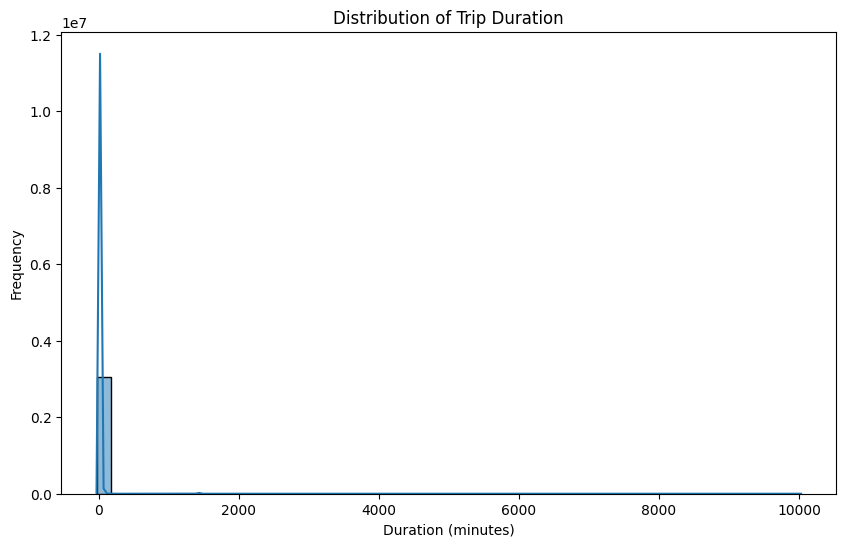

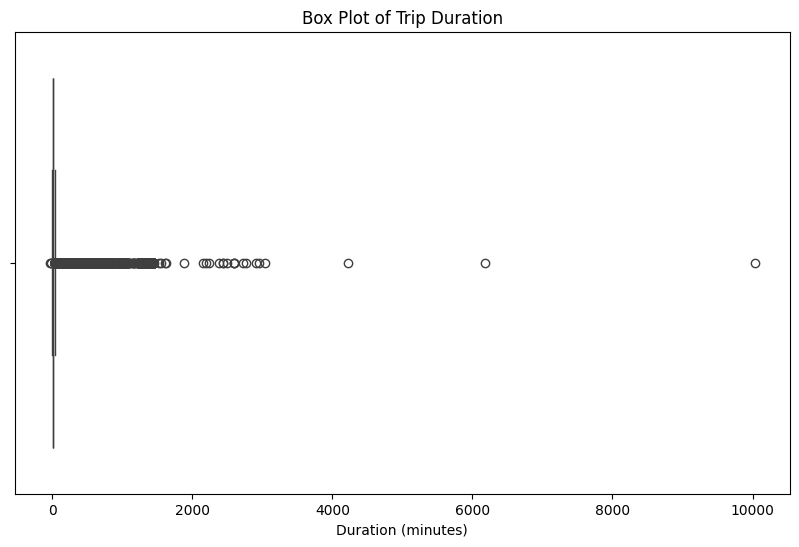

In [10]:
# the distribution plot of duration that showing any outliers

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(jan_trips['duration'], bins=50, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=jan_trips['duration'])
plt.title('Box Plot of Trip Duration')
plt.xlabel('Duration (minutes)')
plt.show()


In [11]:
# 3. The fraction of the records when keeping only the records where the duration is between 1 and 60 minutes

jan_trips_filtered = jan_trips[(jan_trips['duration'] >= 1) & (jan_trips['duration'] <= 60)].copy()

print(f"Original number of records: {len(jan_trips)}")
print(f"Number of records after filtering duration (1-60 mins): {len(jan_trips_filtered)}")
print(f"Percentage of records kept: {len(jan_trips_filtered) / len(jan_trips) * 100:.2f}%")

Original number of records: 3066766
Number of records after filtering duration (1-60 mins): 3009173
Percentage of records kept: 98.12%


In [12]:
jan_trips_filtered.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'duration'],
      dtype='object')

In [13]:
from sklearn.feature_extraction import DictVectorizer

# Select only the relevant columns for one-hot encoding
categorical_features = ['PULocationID', 'DOLocationID']
jan_trips_cat = jan_trips_filtered[categorical_features].copy()

# Convert the location IDs to strings
jan_trips_cat['PULocationID'] = jan_trips_cat['PULocationID'].astype(str)
jan_trips_cat['DOLocationID'] = jan_trips_cat['DOLocationID'].astype(str)

# Turn the dataframe into a list of dictionaries
jan_trips_dict = jan_trips_cat.to_dict(orient='records')

# Fit a dictionary vectorizer
vec = DictVectorizer()
X_train = vec.fit_transform(jan_trips_dict)

In [14]:
# 4. The dimensionality of this matrix (the number of columns)?
print(f"Dimensionality of the feature matrix: {X_train.shape[1]}")

Dimensionality of the feature matrix: 515


In [15]:
# 5. Training a model. RMSE on train
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare target variable
y_train = jan_trips_filtered['duration'].values

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on training data
y_pred = model.predict(X_train)

# Calculate RMSE on training data
rmse = mean_squared_error(y_train, y_pred)
print(f"RMSE on the training data: {np.sqrt(rmse)}")

RMSE on the training data: 7.649261932106969


In [16]:
# setup the validation dataset

feb_trips = pq.read_table(data_feb_23)
feb_trips = feb_trips.to_pandas()

In [17]:
feb_trips.isna().sum()

,0
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,76817
trip_distance,0
RatecodeID,76817
store_and_fwd_flag,76817
PULocationID,0
DOLocationID,0
payment_type,0


In [18]:
# generate duration (in minutes) variable or column
feb_trips['duration'] = (feb_trips['tpep_dropoff_datetime'] - feb_trips['tpep_pickup_datetime']).dt.total_seconds() / 60
feb_trips['duration'].describe()

,duration
count,2.913955e+06
mean,1.601591e+01
std,4.284210e+01
min,-4.361667e+01
25%,7.250000e+00
50%,1.180000e+01
75%,1.876667e+01
max,7.053617e+03


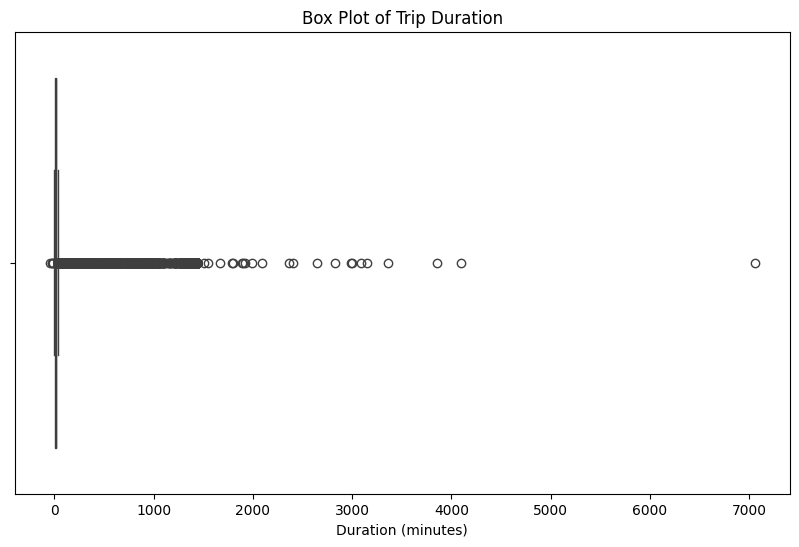

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=feb_trips['duration'])
plt.title('Box Plot of Trip Duration')
plt.xlabel('Duration (minutes)')
plt.show()

In [20]:
feb_trips_filtered = feb_trips[(feb_trips['duration'] >= 1) & (feb_trips['duration'] <= 60)].copy()

# Select only the relevant columns for one-hot encoding
feb_trips_cat = feb_trips_filtered[categorical_features].copy()

# Convert the location IDs to strings
feb_trips_cat['PULocationID'] = feb_trips_cat['PULocationID'].astype(str)
feb_trips_cat['DOLocationID'] = feb_trips_cat['DOLocationID'].astype(str)

# Turn the dataframe into a list of dictionaries
feb_trips_dict = feb_trips_cat.to_dict(orient='records')

# Fit a dictionary vectorizer
X_val = vec.transform(feb_trips_dict)

print(f"Dimensionality of the feature matrix: {X_val.shape[1]}")

Dimensionality of the feature matrix: 515


In [21]:
# 6. Evaluating the model to the validation dataset (Feb 2023)

# Prepare target variable
y_val = feb_trips_filtered['duration'].values

# Predict on training data
y_pred = model.predict(X_val)

# Calculate RMSE on training data
rmse = mean_squared_error(y_val, y_pred)
print(f"RMSE on the validation data: {np.sqrt(rmse)}")

RMSE on the validation data: 7.811818743246608
